# Расчетное задание 1

## Идентификация сообщений, передаваемых по зашумленному каналу связи

### Часть 1. Последовательная передача одинаковых сообщений

#### 1.1. Определение переданного сообщения

##### Исходный алфавит

In [1]:
import alphabet
alph = alphabet.get_alphabet('alphabet.txt')
print(alph)

{'Н': '0011000', ':': '1001111', '3': '0000011', 'Т': '0011101', 'Ф': '0011111', 'н': '0111001', 'Д': '0001110', 'Ъ': '0100111', 'ж': '0110010', '!': '1001110', '.': '1001100', 'ц': '1000010', 'ь': '1000110', '(': '1010100', 'п': '0111011', '-': '1010001', 'и': '0110100', 'М': '0010111', 'Э': '0101000', '0': '0000000', 'у': '0111111', 'К': '0010101', 'ч': '1000011', 'Я': '0101010', 'Ч': '0100010', 'Ь': '0100101', 'ё': '0110001', 'з': '0110011', 'а': '0101011', 'ф': '1000000', 'Б': '0001011', 'Ш': '0100011', 'И': '0010011', 'в': '0101101', '8': '0001000', 'В': '0001100', 'к': '0110110', '№': '1010011', 'ы': '1000111', ')': '1010101', 'я': '1001011', 'р': '0111100', 'Л': '0010110', 'У': '0011110', 'б': '0101100', 'ю': '1001010', 'г': '0101110', 'Г': '0001101', '_': '1010010', '7': '0000111', 'А': '0001010', '4': '0000100', 'м': '0111000', 'й': '0110101', 'Ы': '0100110', 'Й': '0010100', 'Р': '0011011', 'х': '1000001', 'ъ': '1001000', 'П': '0011010', ' ': '1010110', 'Е': '0001111', '6': '0

Словарь априорных вероятностей:

In [2]:
priori = alph.copy()
n = len(alph)
p = 1 / n
for key, value in priori.items():
    priori[key] = p


Функция, находящая максимальное значение в словаре

In [3]:
def find_max(d: dict):
    """Найти в словаре ключ с максимальным значением"""
    return max(d, key=d.get)


##### Входные данные

In [4]:
with open('input.txt', encoding='utf8') as f:
    content = f.readlines()


Колличество букв в каждом сообщении равно $s$:

In [5]:
s = int(content[0].split(': ')[1])
print('s = {s}'.format(s=s))


s = 222


Вероятность искажения каждого отдельного символа (бита) равна $q$, вероятность правильной передачи $p = 1 - q$:

In [6]:
q = float(content[2].split(': ')[1])
p = 1 - q
print('p = {p}, q = {q}'.format(p=p, q=q))


p = 0.832, q = 0.168


Колличествно сообщений (посылок) равно $m$:

In [7]:
m = int(content[3].split(': ')[1])
print('m = {m}'.format(m=m))


m = 18


In [8]:
char_num = 7 # номер буквы, которую будем исследовать в заданиях 1.2 и 2.2

In [9]:
from probability import *
import plots

##### Все символы равновероятны

In [10]:
messages = []

for i in range(m):
    codes = content[i + 4].split(': ')[1].rstrip().split(' ')
    messages.append(codes)


In [11]:
chars = []  # вероятности появления каждого j-ого символа после i-ого сообщения
entropies = []  # значения энтропий каждого j-ого символа после i-ого сообщения
infos = []  # значения кол-ва информации об j-ом символе после i-ого сообщения

char_array = []  # инициализируем априорными вероятностями
for j in range(s):
    char = priori.copy()
    char_array.append(char)
chars.append(char_array)

for i in range(m):  # для каждого сообщения

    entropies_array = []
    info_array = []

    for j in range(s):  # для каждой буквы в сообщении
        entropies_array.append(find_cond_entropy(alph, chars[i][j], messages[i][j]))
        info_array.append(find_info(alph, chars[i][j], messages[i][j]))
        chars[i][j] = find_posterior_probs(alph, chars[i][j], messages[i][j])

    entropies.append(entropies_array)
    infos.append(info_array)

    if i != m - 1:  # априорное для следующего = апостериорное для текущего
        char_array = []
        for j in range(s):
            char = chars[i][j].copy()
            char_array.append(char)
        chars.append(char_array)


In [12]:
for i in range(m):
    print(i + 1, end=': ')
    for j in range(s):
        max_char = find_max(chars[i][j])
        print(max_char, end='')
    print()


1: 8:ЛДьэчимв 4зГЩрТюизьдпПзж:ж235ц1Ё Т вжчННжпк вкБНпыпЯлдчт_заяит пЯ гХНоиб(вевЯчтЮосйиёцуЗНитЩтисШ .ирелЬаМр3чЦТзШЬо,тча. Ял!Л:тжгЯ(ЯоюсебмеЯТ! про.йЩат6(хУЙкРммвкеифКо ззЬа:и(й?ннелЯр.!А№ц(рЯсяЁрн7х када-ж2!кА(и3елаю эдЗ.
2: Д:Л!ьэ3кмв ВпФЩмчьйШ4ЪПУнжы_27525_ь:ЛвжШНУжнжьвйЯНа!пЯЪЪ№У жЯ!Йтьпг_гЭомиЬ вигЯяФнпТкеёцуЛЗегикрса )Кмик5п7ТчыеТёа5Я,ицБ. гё:Л,ЫнДЯ ппУсёбпиЯс: прП.ефатД)фДикнПжвкейфин зпЪаыи кЙМЪжуЯрь!3чЧЛбЯТэетн3х еадэЮжц.Лэ)рБЧлаю(эгП,
3: !, ДьэчЛмв 4ауЩм, изшгттпз:_23Ьъ5Зь, вЧШмжжно вкорпьпЯлучт жачет по№геориЩьвжрЯятнойтеЖМуЛЗеЫЩтисЮ (имикла рБяЦсзавовича. Азя ,тоДо потрертегс: пробе4ать)хти птмвтейфй? зРдпчи к(суелЯть!2-ШЛрЯсчетн7х жадэния. Я(сБжлаю ,дП.
4: г: ДьячЛмв ВадЩм: ил гттпз:_Ч35ъ5_!, вжамжжсо(вкорп пЭлу№т(жачетьпг теории ЮжрЯятносуеЖ уЛЗекЩтинЮ )ймикйа СБяХсёавовица. ДляЛ,того потржбтетс:ьпрпгешать)хуи птмстейфи? зБЪпчи к(суеЪЯть!2-ШЛрЯсхетныщ завЮния. Я с3жлаю .гПД
5: г, ДьячЛов 4ауим, из гттпз: 23Ь81_6, вжамжжно вкоро получу зачет по теорииьЮжроятнойтеК у Пик

In [13]:
for i in range(m):  # для каждого сообщения
    curr = chars[i][char_num]

    title = 'Распределение вероятностей {0}-ой буквы сообщения после {1}-ой посылки'.format(char_num, i + 1)
    save = './../pics/uniform{0}.png'.format(i + 1)
    plots.draw_distribution(alphabet.get_sorted_keys(alph), curr, title, show=False, save=save)


##### Вероятности задаются исходя из частоты встречания букв в русском языке

In [14]:
with open('frequencies.txt', encoding='utf8') as f:
    content = f.readlines()
    frequncies = {}
    content = [x.rstrip().split('\t') for x in content] 
    for pair in content:
        frequncies[pair[0]] = float(pair[1])
        
print(frequncies)


{'р': 5.53, 'б': 1.51, 'ю': 1.03, 'е': 8.1, 'н': 6.35, 'ш': 0.77, 'ж': 0.78, 'з': 1.81, 'г': 1.41, 'а': 8.66, 'ь': 1.9, 'ц': 0.52, 'ф': 0.4, 'у': 2.9, 'с': 5.45, 'й': 1.31, 'э': 0.17, 'п': 3.35, 'д': 2.56, 'в': 4.19, 'я': 2.22, 'х': 0.92, 'ъ': 0.04, 'и': 7.45, 'к': 3.47, 'ч': 1.27, 'о': 9.28, 'ы': 2.11, 'ё': 0.14, 'м': 3.29, 'щ': 0.49, 'т': 6.3, 'л': 4.32}


In [15]:
def get_frequency(char: str):
    """Получить вероятноость встречания символа"""
    assert len(char) == 1
    char = char.lower()
    if char in frequncies.keys():
        return len(frequncies) * priori[char] * frequncies[char] / sum(frequncies.values())
    else:
        return priori[char]


In [16]:
priori_weight = priori.copy()
for key in priori_weight.keys():
    priori_weight[key] = get_frequency(key)
    
print(priori_weight)
print('Sum = ' + str(sum(priori_weight.values())))


{'Н': 0.02408620689655172, ':': 0.011494252873563218, '3': 0.011494252873563218, 'Т': 0.02389655172413793, 'Ф': 0.0015172413793103448, 'н': 0.02408620689655172, 'Д': 0.009710344827586207, 'Ъ': 0.00015172413793103449, 'ж': 0.0029586206896551727, '!': 0.011494252873563218, '.': 0.011494252873563218, 'ц': 0.0019724137931034485, 'ь': 0.007206896551724137, '(': 0.011494252873563218, 'п': 0.012706896551724139, '-': 0.011494252873563218, 'и': 0.02825862068965517, 'М': 0.012479310344827585, 'Э': 0.0006448275862068966, '0': 0.011494252873563218, 'К': 0.013162068965517242, 'ч': 0.004817241379310344, 'Я': 0.008420689655172415, 'Ч': 0.004817241379310344, 'Ь': 0.007206896551724137, 'ё': 0.0005310344827586207, 'з': 0.00686551724137931, 'а': 0.03284827586206896, 'ф': 0.0015172413793103448, 'у': 0.011, 'Ш': 0.002920689655172414, 'И': 0.02825862068965517, 'в': 0.015893103448275863, '8': 0.011494252873563218, 'В': 0.015893103448275863, 'к': 0.013162068965517242, '№': 0.011494252873563218, 'ы': 0.0080034

In [17]:
chars_weight = []  # вероятности появления каждого j-ого символа после i-ого сообщения
entropies_weight = []  # значения энтропий каждого j-ого символа после i-ого сообщения
infos_weight = []  # значения кол-ва информации об j-ом символе после i-ого сообщения

char_array = []  # инициализируем априорными вероятностями
for j in range(s):
    char = priori_weight.copy()
    char_array.append(char)
chars_weight.append(char_array)

for i in range(m):  # для каждого сообщения

    entropies_array = []
    info_array = []

    for j in range(s):  # для каждой буквы в сообщении
        entropies_array.append(find_cond_entropy(alph, chars_weight[i][j], messages[i][j]))
        info_array.append(find_info(alph, chars_weight[i][j], messages[i][j]))
        chars_weight[i][j] = find_posterior_probs(alph, chars_weight[i][j], messages[i][j])

    entropies_weight.append(entropies_array)
    infos_weight.append(info_array)

    if i != m - 1:  # априорное для следующего = постериорное для текущего
        char_array = []
        for j in range(s):
            char = chars_weight[i][j].copy()
            char_array.append(char)
        chars_weight.append(char_array)


In [18]:
for i in range(m):
    print(i + 1, end=': ')
    for j in range(s):
        max_char = find_max(chars_weight[i][j])
        print(max_char, end='')
    print()


1: 8:ЛДь9чимв 4зЕирТПизьдпПзо:_235_1е Т воаНН_пк вкаНпыпЯлдчт_заяит пЯ геНоиб(вевЯчтаосиие_уЗНититиса СирелЬаМр3ч1ТзаЬо,тча. Ял!Л:тогЯ(ЯоПсебмеЯТ! проСииат6(хУикРммвкеи0Ко ззЬа:и(и?ннелЯр.!А№Ч(рЯсяерн7х када-_2!кА(и3елаА 9дЗ.
2: А,ЛА6э3инв ВаЕХр:_изЛдОоозЕ_235А5_ :ЛвоШНо_но виоНаАпАлл№т за!ет!по№теооии вето№тноТЕеЖИуЛНетиоиса (иреллаЛТ3:еТИаво,очаВ Ал:Л:тоДо(ооореиоеоТ: проре4ат!(-текОоовтеи.ио(зова:и(иеОоелЯт!!А-еЛрЯТяетнИх еадаееА.та(и3елаю(,тП,
3: !, Дь,чЛмв 4ауим, изшгттпз:_23Ь85Зь, вЧаможно вкорпьпЯлучт еачет по№георииьверЯятнойтеЖМуЛЗеЫитиса (имикла рЕяЦсзавовича. Азя ,тоДо потрертегс: пробе4ать)хти птмвтеифие зРдпчи к(суелЯть!2-ШЛрЯсчетн7х оадания. Я(саелаю ,дП.
4: гЕ Д!ячЛов Вауим, ил(Ыттпз:_23585_!, вЧамжжно влоро полу№т(зачет по теории(вероятностеК уЛПекЩтина Кирилла ряяХсИавовича, АляЛ,тоДо потреитетс: проте4ат6(хти птостейшие задачи и сселАть!2-3ЛраТчетн7х завания. а саелаю(.тПВ
5: г, ДьячЛов 4ауим, из гттпз: 23Ь81_6, воаможно вкоро получу зачет по теорииьЮероятнойтеК у Пик

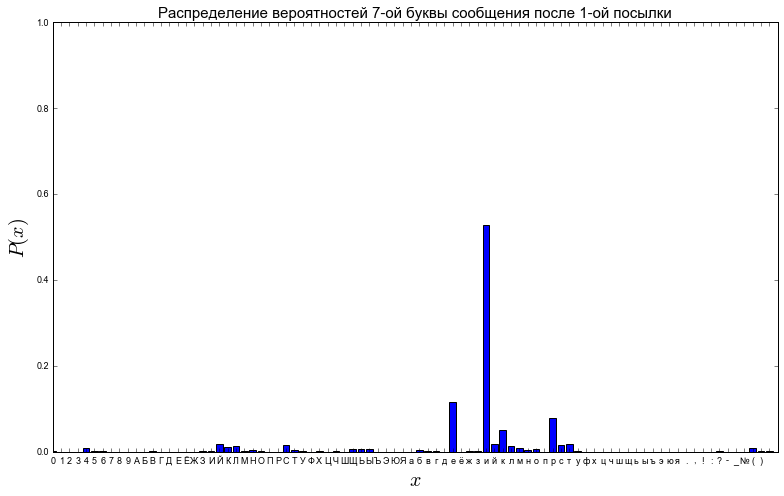

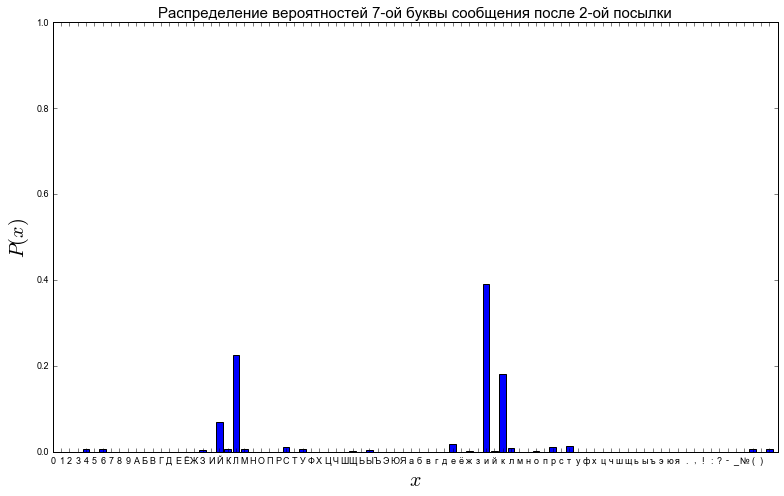

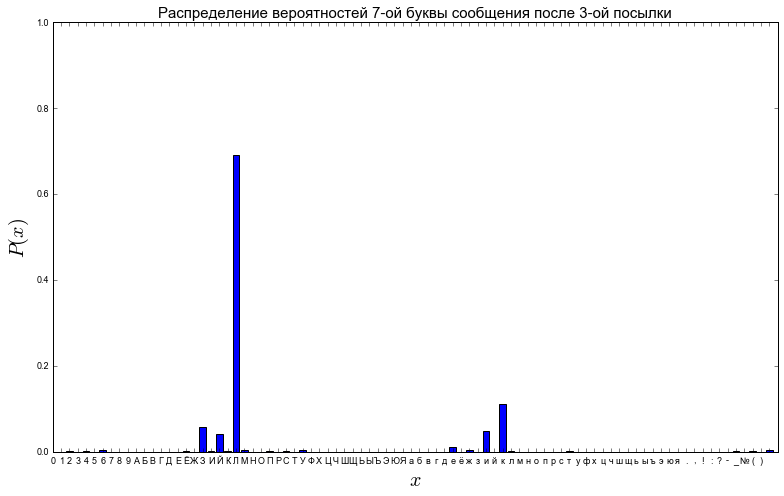

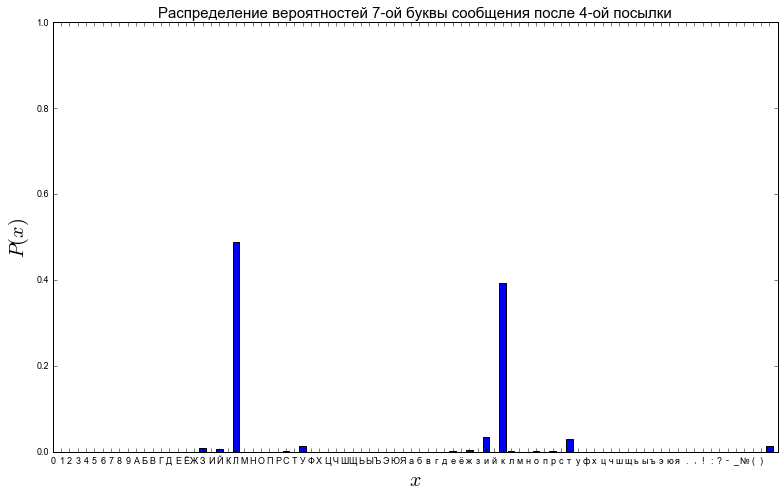

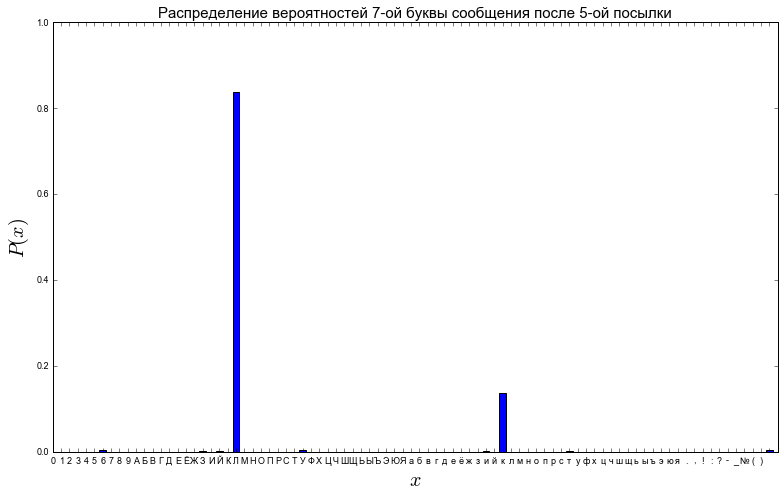

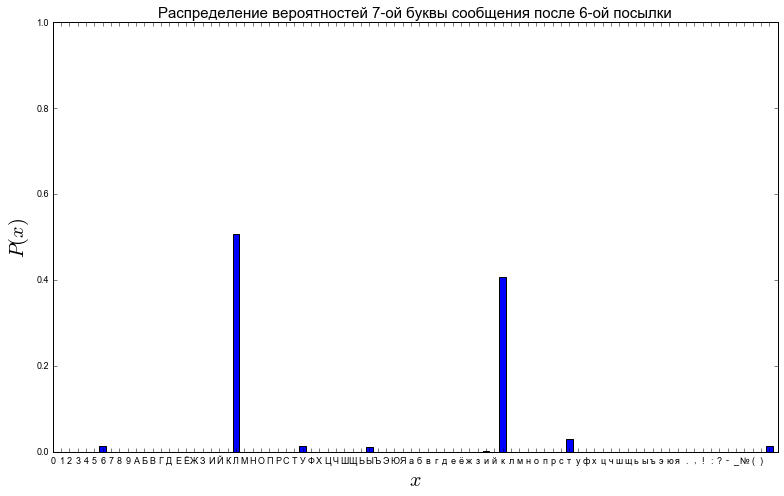

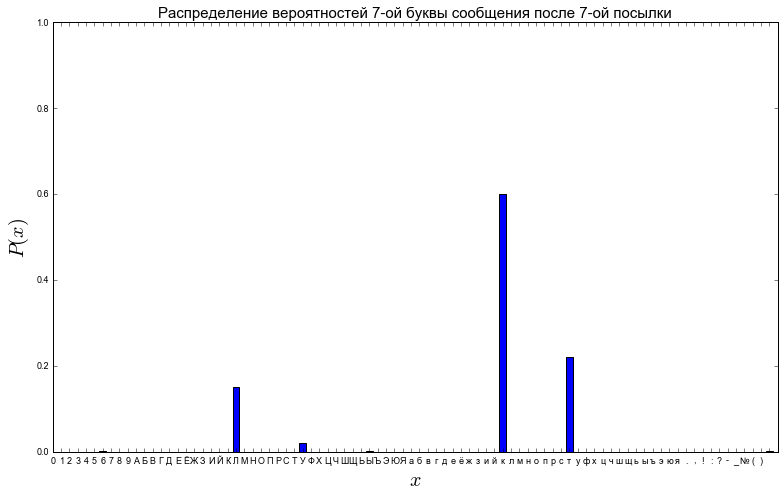

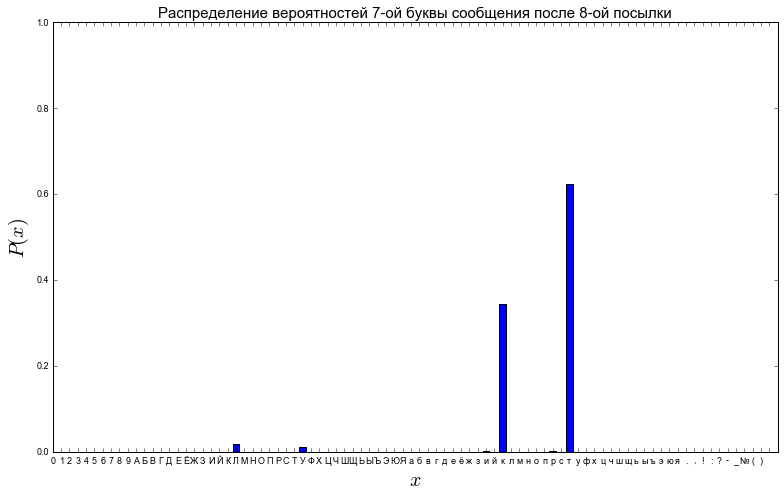

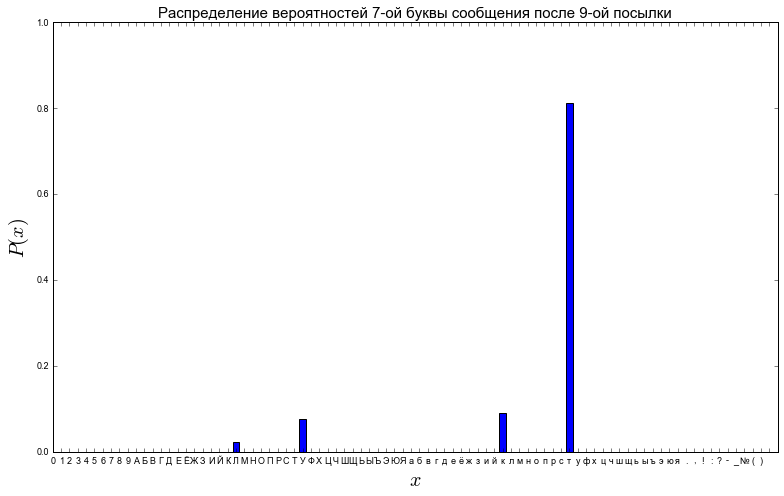

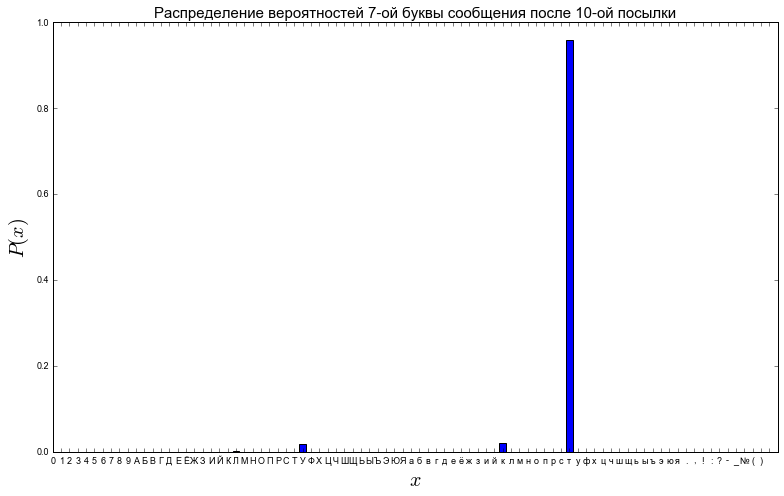

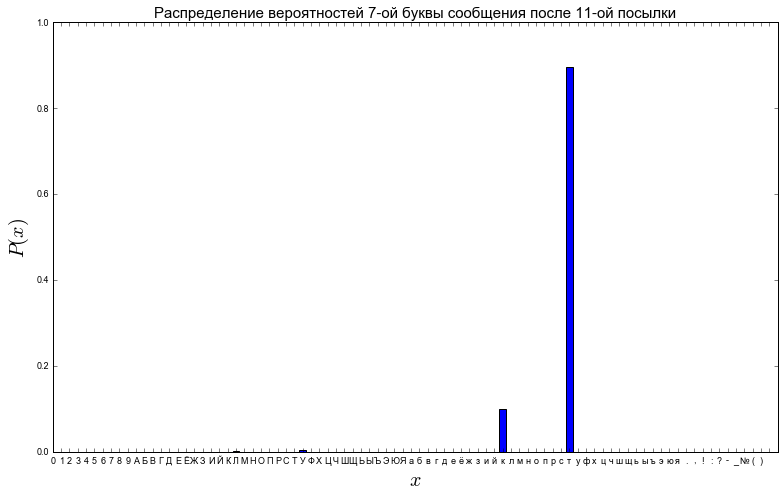

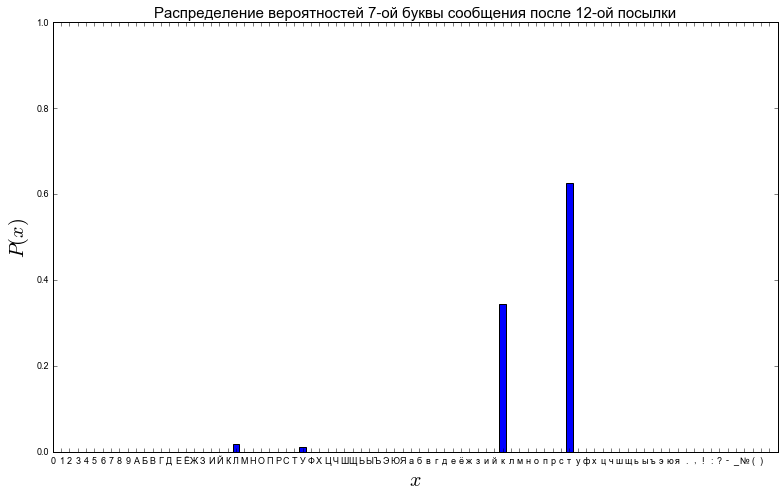

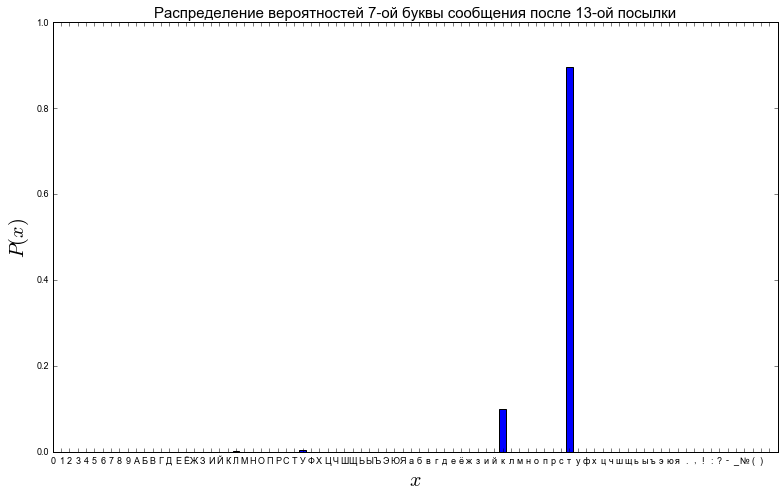

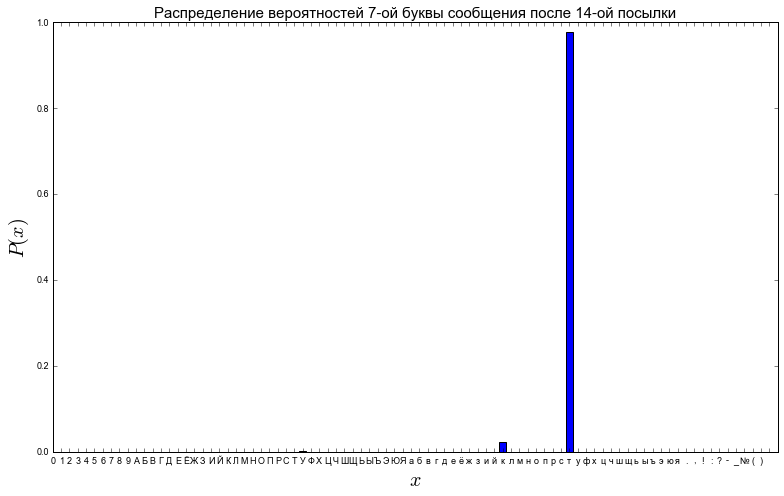

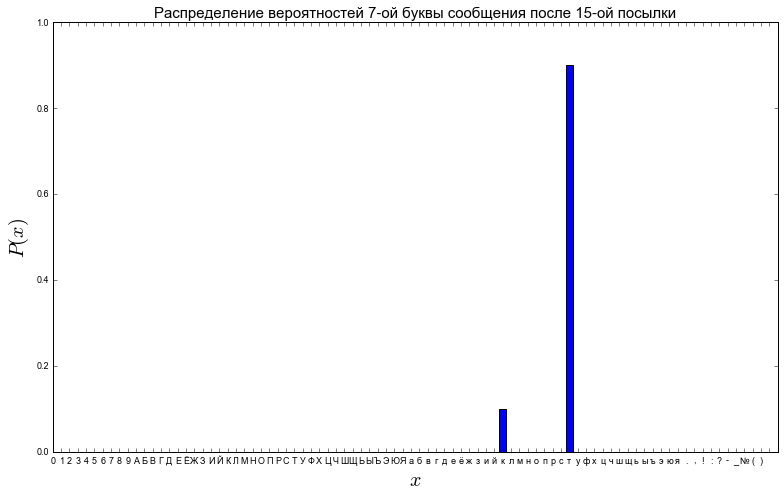

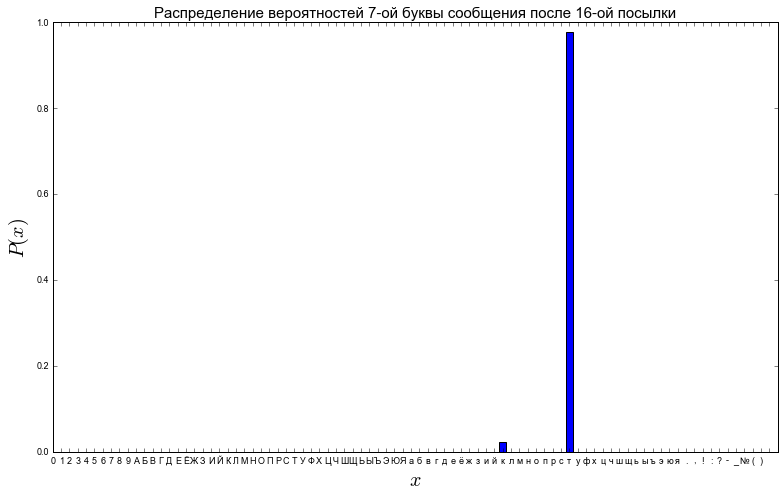

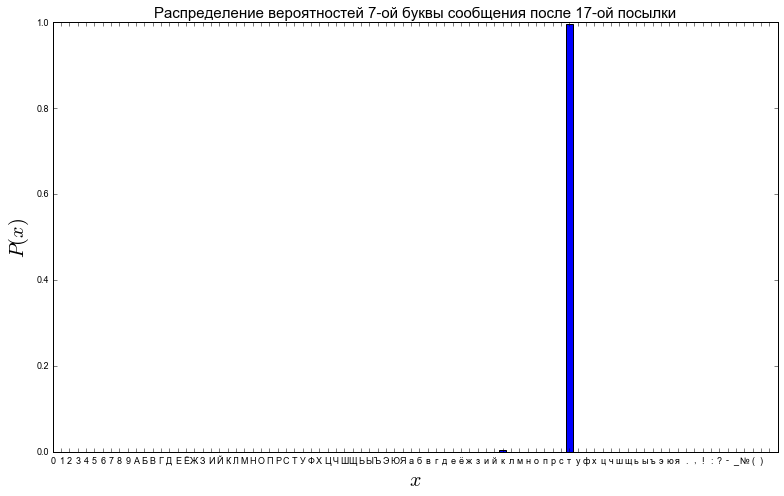

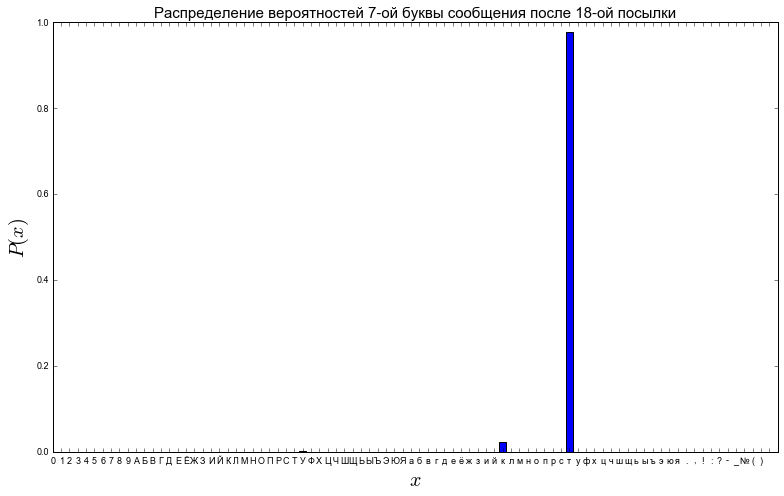

In [19]:
for i in range(m):  # для каждого сообщения
    curr = chars_weight[i][char_num]

    title = 'Распределение вероятностей {0}-ой буквы сообщения после {1}-ой посылки'.format(char_num, i + 1)
    plots.draw_distribution(alphabet.get_sorted_keys(alph), curr, title, show=True)


Из результатов видно, что в ситуации, когда вероятности задаются ихсодя из частоты встречания букв в русском языке, зашумленное сообщение было распознано немного быстрее.

#### 1.2. Расчет энтропии и количества информации

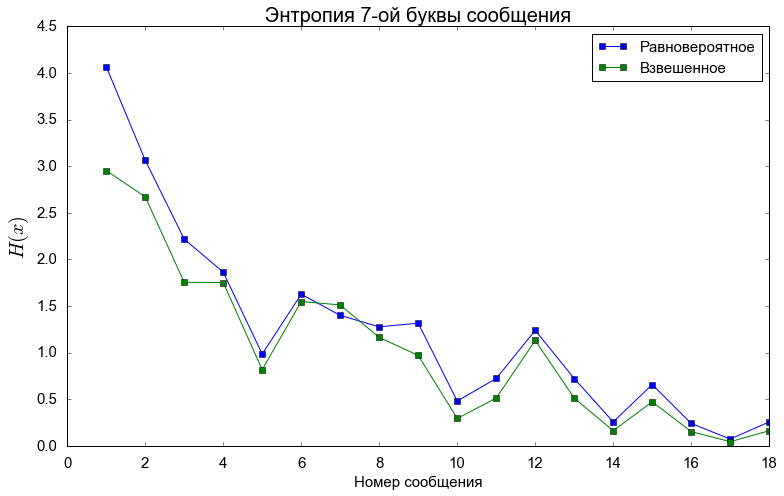

In [20]:
x = range(1, m+1)
h_u = []
h_w = []

for i in range(m):
    h_u.append(entropies[i][char_num])
    h_w.append(entropies_weight[i][char_num])
    
plots.draw_entropy(x, h_u, h_w, title='Энтропия {0}-ой буквы сообщения'.format(char_num, i + 1))


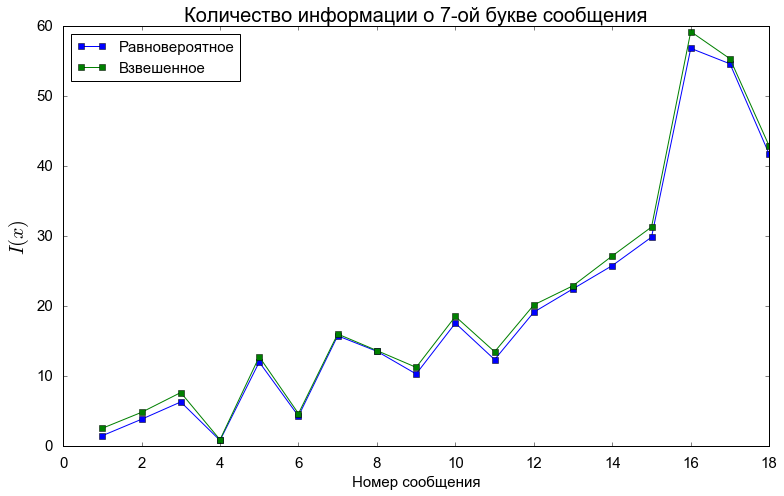

In [21]:
x = range(1, m+1)
i_u = []
i_w = []
    
for i in range(m):
    i_u.append(infos[i][char_num])
    i_w.append(infos_weight[i][char_num])
    
plots.draw_info(x, i_u, i_w, title='Количество информации о {0}-ой букве сообщения'.format(char_num, i + 1))


Средняя условная энтропия $H(X|Y)$ и среднее количество информации $I(X|Y)$: 

In [22]:
msgs = []
for i in range(m):
    msgs.append(messages[i][char_num])

print('H_uniform(X|Y) = {h}'.format(h=find_avg_entropy(alph, priori, msgs)))
print('I_uniform(X|Y) = {i}'.format(i=find_avg_info(alph, priori, msgs)))
print('H_weighted(X|Y) = {h}'.format(h=find_avg_entropy(alph, priori_weight, msgs)))
print('I_weighted(X|Y) = {i}'.format(i=find_avg_info(alph, priori_weight, msgs)))

H_uniform(X|Y) = 0.8616924025101423
I_uniform(X|Y) = 5.58125109333858
H_weighted(X|Y) = 1.2354422110832062
I_weighted(X|Y) = 4.7944082929790675


### Часть 2 Передача сообщения путем многократного дублирования

#### Все символы равновероятны

In [23]:
long_alph = alph.copy()

for key in long_alph.keys():
    long_alph[key] = long_alph[key] * 18

In [24]:
long_chars = []  # вероятности появления каждого j-ого символа инициализируем априорными вероятностями
long_entropies = []  # значения энтропий каждого j-ого символа
long_infos = []  # значения кол-ва информации об j-ом символе
for j in range(s):
    char = priori.copy()
    long_chars.append(char)

for j in range(s):  # для каждой буквы в сообщении
    long_char = ''
    for i in range(m):  # для каждого сообщения
        long_char = long_char + messages[i][j]
    long_chars[j] = find_posterior_probs(long_alph, long_chars[j], long_char)
    long_entropies.append(find_cond_entropy(long_alph, long_chars[j], long_char))
    long_infos.append(find_info(long_alph, long_chars[j], long_char))

In [25]:
for j in range(s):
    max_char = find_max(long_chars[j])
    print(max_char, end='')
print()

Я, Дьячтов Вадим, из группы 23501_4, возможно скоро получу зачет по теории вероятностей у Никитина Кирилла Вячеславовича. Для этого потребуется прорешать эти простейшие задачи и сделать 2-3 расчетных задания. Я сделаю это!


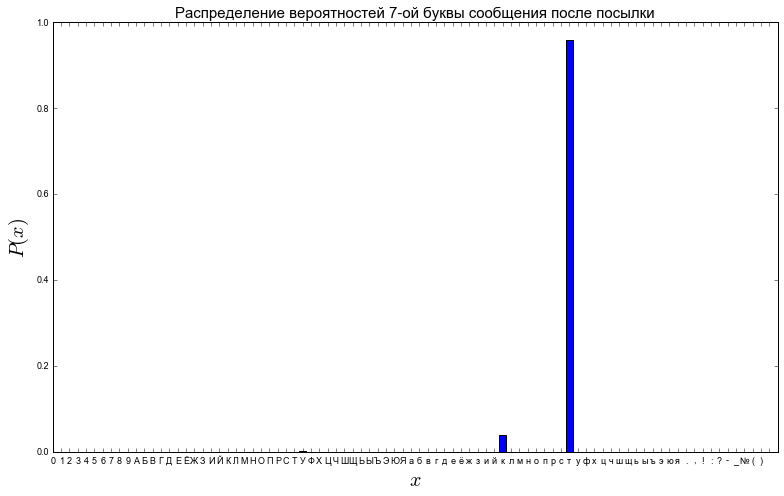

In [26]:
curr = long_chars[char_num]
    
title = 'Распределение вероятностей {0}-ой буквы сообщения после посылки'.format(char_num)
plots.draw_distribution(alphabet.get_sorted_keys(long_alph), curr, title, show=True)


#### Вероятности задаются исходя из частоты встречания букв в русском языке

In [27]:
long_chars_weight = []  # вероятности появления каждого j-ого символа инициализируем априорными вероятностями
long_entropies_weight = []  # значения энтропий каждого j-ого символа
long_infos_weight = []  # значения кол-ва информации об j-ом символе
for j in range(s):
    char = priori_weight.copy()
    long_chars_weight.append(char)

for j in range(s):  # для каждой буквы в сообщении
    long_char = ''
    for i in range(m):  # для каждого сообщения
        long_char = long_char + messages[i][j]
    long_entropies_weight.append(find_cond_entropy(long_alph, long_chars_weight[j], long_char))
    long_infos_weight.append(find_info(long_alph, long_chars_weight[j], long_char))
    long_chars_weight[j] = find_posterior_probs(long_alph, long_chars_weight[j], long_char)

In [28]:
for j in range(s):
    max_char = find_max(long_chars[j])
    print(max_char, end='')
print()

Я, Дьячтов Вадим, из группы 23501_4, возможно скоро получу зачет по теории вероятностей у Никитина Кирилла Вячеславовича. Для этого потребуется прорешать эти простейшие задачи и сделать 2-3 расчетных задания. Я сделаю это!


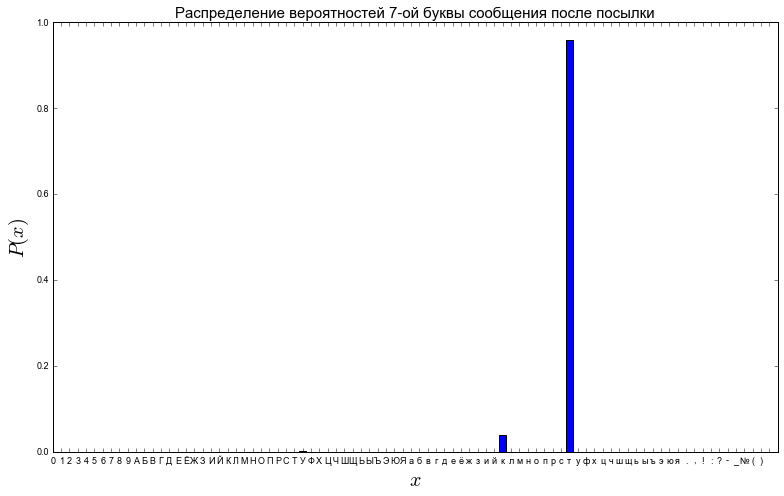

In [29]:
curr = long_chars[char_num]

title = 'Распределение вероятностей {0}-ой буквы сообщения после посылки'.format(char_num)
plots.draw_distribution(alphabet.get_sorted_keys(long_alph), curr, title, show=True)

#### 2.2. Расчет энтропии и количества информации

In [30]:
print('H_uniform(X|Y) = {h}'.format(h=long_entropies[char_num]))
print('H_uniform(X|Y) = {h}'.format(h=long_entropies_weight[char_num]))

H_uniform(X|Y) = 0.017774318982661793
H_uniform(X|Y) = 0.16180743366244252


In [31]:
print(long_infos[char_num])
print(long_infos_weight[char_num])

-0.017774318982661793
-0.16180743366244252


In [32]:
msgs = []
for j in range(s):  # для каждой буквы в сообщении
    long_char = ''
    for i in range(m):  # для каждого сообщения
        long_char = long_char + messages[i][j]
    msgs.append(long_char)

print('H_uniform(X|Y) = {h}'.format(h=find_avg_entropy(long_alph, priori, msgs)))
print('I_uniform(X|Y) = {i}'.format(i=find_avg_info(long_alph, priori, msgs)))
print('H_weighted(X|Y) = {h}'.format(h=find_avg_entropy(long_alph, priori_weight, msgs)))
print('I_weighted(X|Y) = {i}'.format(i=find_avg_info(long_alph, priori_weight, msgs)))

H_uniform(X|Y) = 0.016388735257036012
I_uniform(X|Y) = 6.426554760591687
H_weighted(X|Y) = 0.01844609666267506
I_weighted(X|Y) = 6.011404407399598
